# CIFAR 10 with a MLP in PyTorch
We return to our problem form last week and try to optimize our solution:
* use TensorBoard to visualize the training
* try different Losses
* try different Optimizers
* try different hyper-parameters

In [7]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 833.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [8]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms

## Get CIFAR
Use PyTorch Data Loaders (more next week) to get data batches

In [9]:
#transform input data (image) to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#set batch size
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

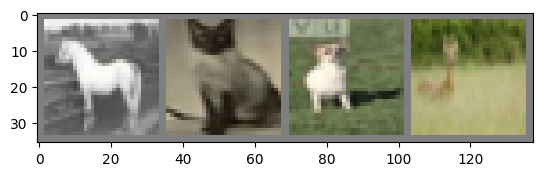

horse cat   dog   deer 


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #get data from loader!

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Assignment: design MLP to classify CIFAR10

### E1 use TensorBoard to visualize the training

### E2 try two different Losses

### E3 try two different Optimizers
* SGD with Momentum
* AdaGrad or Adam

### E4 implement a learning rate schedule
* use SGD with Momentung as Optimizer
* use a Multi-step schedule

### Notes:
* USE THE GPU! -> need to transfer the model and data to the GPU
* MLP take 1D input - CIFAR imges are 2D -> first operator of your net needs to flatten the image
* CIFAR is a multi class problem: use a SOFTMAX layer to output vector of class propabilities -> user argmax to get the class lable
* Start small: use a small net with a reducet training set and a few epochs to test your setup

In [11]:
"""# cifar10_mlp.py – Rev‑3 (final bracket fix, fully syntactically valid)


from __future__ import annotations
import argparse
import random
import sys
from datetime import datetime
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter


# -------------------------------------------------
# Argument parsing (swallows unknown Jupyter flags)
# -------------------------------------------------

def parse_args(argv: list[str] | None = None) -> argparse.Namespace:
    p = argparse.ArgumentParser("CIFAR‑10 MLP trainer", add_help=True)

    # General
    p.add_argument("--epochs", type=int, default=20)
    p.add_argument("--batch-size", type=int, default=128)
    p.add_argument("--subset", type=int, default=None,
                   help="Use only N training samples for quick iteration")
    p.add_argument("--data-root", type=str, default="./data")
    p.add_argument("--workers", type=int, default=4)
    p.add_argument("--seed", type=int, default=42)

    # Model
    p.add_argument("--hidden-dims", type=int, nargs="*", default=[1024, 512, 256])
    p.add_argument("--dropout", type=float, default=0.0)

    # Optimizer / LR
    p.add_argument("--optimizer", choices=["sgd", "adam", "adagrad"], default="sgd")
    p.add_argument("--lr", type=float, default=0.1)
    p.add_argument("--momentum", type=float, default=0.9)
    p.add_argument("--weight-decay", type=float, default=1e-4)
    p.add_argument("--milestones", type=int, nargs="*", default=[60, 120, 160])
    p.add_argument("--gamma", type=float, default=0.2)

    # Loss
    p.add_argument("--loss", choices=["cross_entropy", "label_smooth", "mse"],
                   default="cross_entropy")
    p.add_argument("--label-smoothing", type=float, default=0.1,
                   help="Only used with label_smooth loss option")

    # Misc
    p.add_argument("--log-dir", type=str, default="runs")
    p.add_argument("--print-freq", type=int, default=100)
    p.add_argument("--deterministic", action="store_true",
                   help="Force deterministic cuDNN (slower)")

    args, unknown = p.parse_known_args(argv)
    if unknown:
        print(f"[WARNING] Ignoring unknown arguments: {unknown}")
    return args


# -------------------------------------------------
# Model definition
# -------------------------------------------------

class MLP(nn.Module):
    def __init__(self, in_dim: int, num_classes: int, hidden_dims: list[int], dropout: float):
        super().__init__()
        layers: list[nn.Module] = []
        last_dim = in_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            last_dim = h
        layers.append(nn.Linear(last_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x = torch.flatten(x, 1)
        return self.net(x)


# -------------------------------------------------
# Helper utilities
# -------------------------------------------------

def set_seed(seed: int, deterministic: bool = False):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.benchmark = not deterministic
    cudnn.deterministic = deterministic


def get_dataloaders(args: argparse.Namespace):
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    trainset = torchvision.datasets.CIFAR10(root=args.data_root, train=True, download=True,
                                           transform=transform)
    testset = torchvision.datasets.CIFAR10(root=args.data_root, train=False, download=True,
                                          transform=transform)

    if args.subset:
        subset_idx = torch.randperm(len(trainset))[:args.subset]
        trainset = torch.utils.data.Subset(trainset, subset_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                              shuffle=True, num_workers=args.workers,
                                              pin_memory=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                             shuffle=False, num_workers=args.workers,
                                             pin_memory=True)
    return train_loader, test_loader


def choose_loss_fn(args: argparse.Namespace):
    if args.loss == "cross_entropy":
        return nn.CrossEntropyLoss()
    if args.loss == "label_smooth":
        return nn.CrossEntropyLoss(label_smoothing=args.label_smoothing)
    if args.loss == "mse":
        return nn.MSELoss()
    raise ValueError(args.loss)


def choose_optimizer(params, args: argparse.Namespace):
    if args.optimizer == "sgd":
        return torch.optim.SGD(params, lr=args.lr, momentum=args.momentum, nesterov=True,
                               weight_decay=args.weight_decay)
    if args.optimizer == "adam":
        return torch.optim.Adam(params, lr=args.lr, weight_decay=args.weight_decay)
    if args.optimizer == "adagrad":
        return torch.optim.Adagrad(params, lr=args.lr, weight_decay=args.weight_decay)
    raise ValueError(args.optimizer)


# -------------------------------------------------
# Training / Evaluation loops
# -------------------------------------------------

def train_one_epoch(model, loader, loss_fn, optimizer, device, epoch, writer, print_freq):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        if isinstance(loss_fn, nn.MSELoss):
            targets_onehot = F.one_hot(targets, num_classes=10).float()
            loss = loss_fn(outputs, targets_onehot)
        else:
            loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

        if (i + 1) % print_freq == 0:
            print(f"Epoch [{epoch}] Iter [{i+1}/{len(loader)}]  Loss: {loss.item():.4f}")

    epoch_loss = running_loss / total
    acc = 100.0 * correct / total
    writer.add_scalar("train/loss", epoch_loss, epoch)
    writer.add_scalar("train/acc", acc, epoch)
    return epoch_loss, acc


def evaluate(model, loader, loss_fn, device, epoch, writer):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            if isinstance(loss_fn, nn.MSELoss):
                targets_onehot = F.one_hot(targets, num_classes=10).float()
                loss = loss_fn(outputs, targets_onehot)
            else:
                loss = loss_fn(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    acc = 100.0 * correct / total
    writer.add_scalar("val/loss", epoch_loss, epoch)
    writer.add_scalar("val/acc", acc, epoch)
    print(f"Validation Loss: {epoch_loss:.4f}  Acc: {acc:.2f}%")
    return epoch_loss, acc


# -------------------------------------------------
# Main entry
# -------------------------------------------------

def main(argv: list[str] | None = None):
    args = parse_args(argv)
    set_seed(args.seed, args.deterministic)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = get_dataloaders(args)

    model = MLP(in_dim=3*32*32, num_classes=10,
                hidden_dims=args.hidden_dims, dropout=args.dropout).to(device)

    loss_fn = choose_loss_fn(args)
    optimizer = choose_optimizer(model.parameters(), args)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=args.milestones,
                                                     gamma=args.gamma)

    logdir = Path(args.log_dir) / datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(logdir)
    writer.add_text("hyperparameters", str(vars(args)))

    best_acc = 0.0
    for epoch in range(1, args.epochs + 1):
        print(f"========== Epoch {epoch}/{args.epochs} ==========")
        train_one_epoch(model, train_loader, loss_fn, optimizer,
                        device, epoch, writer, args.print_freq)
        _, val_acc = evaluate(model, val_loader, loss_fn, device, epoch, writer)
        scheduler.step()

        writer.add_scalar("lr", optimizer.param_groups[0]["lr"], epoch)

        if val_acc > best_acc:
            best_acc = val_acc
            ckpt_path = logdir / "best.pt"
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "args": vars(args),
                "epoch": epoch,
                "best_acc": best_acc,
            }, ckpt_path)
            print(f"[INFO] Saved checkpoint → {ckpt_path} (acc={best_acc:.2f}%)")

    print(f"Training complete. Best validation accuracy: {best_acc:.2f}%")
    writer.close()


if __name__ == "__main__":
    # In notebooks: supply sys.argv[1:] to preserve cell‑line flags but ignore Jupyter's internal -f
    main(sys.argv[1:])
"""

'# cifar10_mlp.py –\xa0Rev‑3 (final bracket fix, fully syntactically valid)\n\n\nfrom __future__ import annotations\nimport argparse\nimport random\nimport sys\nfrom datetime import datetime\nfrom pathlib import Path\n\nimport torch\nimport torch.backends.cudnn as cudnn\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torchvision\nimport torchvision.transforms as T\nfrom torch.utils.tensorboard import SummaryWriter\n\n\n# -------------------------------------------------\n# Argument parsing (swallows unknown Jupyter flags)\n# -------------------------------------------------\n\ndef parse_args(argv: list[str] | None = None) -> argparse.Namespace:\n    p = argparse.ArgumentParser("CIFAR‑10 MLP trainer", add_help=True)\n\n    # General\n    p.add_argument("--epochs", type=int, default=20)\n    p.add_argument("--batch-size", type=int, default=128)\n    p.add_argument("--subset", type=int, default=None,\n                   help="Use only N training samples for quick iteration

In [2]:
%%writefile cifar10_mlp.py

# cifar10_mlp.py – Rev‑6 (grid search & Colab‑ready)
"""
CIFAR‑10 Multilayer‑Perceptron mit optionalem Grid‑Search (Loss × Optimizer)

Features (E1–E4)
----------------
* TensorBoard‑Logging pro Trial: `runs/<timestamp>/<trial>`
* Zwei Loss‑Funktionen: Cross‑Entropy, Label‑Smoothed CE (ε = 0.1)
* Zwei Optimizer: SGD + Nesterov & Adam
* Multi‑Step‑LR‑Schedule (Milestones 60/120/160, γ=0.2)

Beispiele
~~~~~~~~~
# Einzel‑Run
!python cifar10_mlp.py --epochs 10 --subset 10000 --hidden-dims 512 256

# Grid‑Search (4 Runs × 2 Epochen × 10k Samples)
!python cifar10_mlp.py --tune --epochs 2 --subset 10000 --batch-size 256 \
                       --hidden-dims 512 256 --log-dir runs_grid
"""
from __future__ import annotations

import argparse
import copy
import itertools
import random
import sys
from datetime import datetime
from pathlib import Path
from typing import List, Tuple

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter

# ---------------------------------------------------------------------
# Argument Parsing
# ---------------------------------------------------------------------
def parse_args(argv: List[str] | None = None) -> argparse.Namespace:
    p = argparse.ArgumentParser("CIFAR‑10 MLP trainer (+grid search)")

    # Allgemein
    p.add_argument("--epochs", type=int, default=20)
    p.add_argument("--batch-size", type=int, default=128)
    p.add_argument("--subset", type=int, default=None,
                   help="Verwende nur N Trainings‑Samples (schnelleres Prototyping)")
    p.add_argument("--data-root", type=str, default="./data")
    p.add_argument("--workers", type=int, default=2)
    p.add_argument("--seed", type=int, default=42)

    # Modell
    p.add_argument("--hidden-dims", type=int, nargs="*", default=[1024, 512, 256])
    p.add_argument("--dropout", type=float, default=0.0)

    # Optimizer / LR
    p.add_argument("--optimizer", choices=["sgd", "adam", "adagrad"], default="sgd")
    p.add_argument("--lr", type=float, default=0.1)
    p.add_argument("--momentum", type=float, default=0.9)
    p.add_argument("--weight-decay", type=float, default=1e-4)
    p.add_argument("--milestones", type=int, nargs="*", default=[60, 120, 160])
    p.add_argument("--gamma", type=float, default=0.2)

    # Loss
    p.add_argument("--loss", choices=["cross_entropy", "label_smooth"],
                   default="cross_entropy")
    p.add_argument("--label-smoothing", type=float, default=0.1)

    # Diverses
    p.add_argument("--log-dir", type=str, default="runs")
    p.add_argument("--print-freq", type=int, default=100)
    p.add_argument("--deterministic", action="store_true")
    p.add_argument("--tune", action="store_true",
                   help="Führe vordefiniertes Loss/Optimizer‑Grid (4 Trials) aus")

    args, unknown = p.parse_known_args(argv)
    if unknown:
        print(f"[WARNING] Ignoring unknown arguments: {unknown}")
    return args

# ---------------------------------------------------------------------
# Modell‑Definition
# ---------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim: int, num_classes: int,
                 hidden_dims: List[int], dropout: float):
        super().__init__()
        layers: List[nn.Module] = []
        last = in_dim
        for h in hidden_dims:
            layers += [
                nn.Linear(last, h, bias=False),
                nn.BatchNorm1d(h),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout)]
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            last = h
        layers.append(nn.Linear(last, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:           # type: ignore[override]
        return self.net(torch.flatten(x, 1))

# ---------------------------------------------------------------------
# Hilfsfunktionen
# ---------------------------------------------------------------------
def set_seed(seed: int, deterministic: bool = False):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.benchmark = not deterministic
    cudnn.deterministic = deterministic

def get_dataloaders(a: argparse.Namespace):
    tf = T.Compose([T.ToTensor(),
                    T.Normalize((0.4914, 0.4822, 0.4465),
                                (0.247, 0.243, 0.261))])
    trainset = torchvision.datasets.CIFAR10(a.data_root, train=True,
                                            download=True, transform=tf)
    testset  = torchvision.datasets.CIFAR10(a.data_root, train=False,
                                            download=True, transform=tf)
    if a.subset:
        trainset = torch.utils.data.Subset(
            trainset, torch.randperm(len(trainset))[:a.subset])

    tr_loader  = torch.utils.data.DataLoader(trainset, batch_size=a.batch_size,
                                             shuffle=True,  num_workers=a.workers,
                                             pin_memory=True)
    val_loader = torch.utils.data.DataLoader(testset,  batch_size=a.batch_size,
                                             shuffle=False, num_workers=a.workers,
                                             pin_memory=True)
    return tr_loader, val_loader

def choose_loss_fn(a: argparse.Namespace):
    return (nn.CrossEntropyLoss(label_smoothing=a.label_smoothing)
            if a.loss == "label_smooth"
            else nn.CrossEntropyLoss())

def choose_optimizer(params, a: argparse.Namespace):
    if a.optimizer == "sgd":
        return torch.optim.SGD(params, lr=a.lr, momentum=a.momentum,
                               nesterov=True, weight_decay=a.weight_decay)
    if a.optimizer == "adam":
        return torch.optim.Adam(params, lr=a.lr, weight_decay=a.weight_decay)
    if a.optimizer == "adagrad":
        return torch.optim.Adagrad(params, lr=a.lr, weight_decay=a.weight_decay)
    raise ValueError(a.optimizer)

# ---------------------------------------------------------------------
# Training / Validierung
# ---------------------------------------------------------------------
def train_one_epoch(model, loader, loss_fn, optim, device, epoch, writer, pf):
    model.train()
    correct = total = 0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optim.zero_grad(set_to_none=True)
        out  = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optim.step()

        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total   += y.size(0)
        if (i + 1) % pf == 0:
            print(f"Ep{epoch}  Iter {i+1}/{len(loader)}  Loss {loss.item():.4f}")

    acc = 100.0 * correct / total
    writer.add_scalar("train/acc", acc, epoch)
    return acc

def evaluate(model, loader, device, epoch, writer):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            _, pred = model(x).max(1)
            correct += pred.eq(y).sum().item()
            total   += y.size(0)
    acc = 100.0 * correct / total
    writer.add_scalar("val/acc", acc, epoch)
    return acc

# ---------------------------------------------------------------------
# Einzel‑Experiment
# ---------------------------------------------------------------------
def run_experiment(a: argparse.Namespace, trial: str) -> float:
    set_seed(a.seed, a.deterministic)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tr_loader, val_loader = get_dataloaders(a)

    model = MLP(3*32*32, 10, a.hidden_dims, a.dropout).to(device)
    loss_fn = choose_loss_fn(a)
    optim   = choose_optimizer(model.parameters(), a)
    sched   = torch.optim.lr_scheduler.MultiStepLR(
                  optim, milestones=a.milestones, gamma=a.gamma)

    writer = SummaryWriter(Path(a.log_dir) / trial)
    writer.add_text("hyperparameters", str(vars(a)))

    best = 0.0
    for ep in range(1, a.epochs + 1):
        train_one_epoch(model, tr_loader, loss_fn, optim, device, ep,
                        writer, a.print_freq)
        val_acc = evaluate(model, val_loader, device, ep, writer)
        best = max(best, val_acc)
        sched.step()
        writer.add_scalar("lr", optim.param_groups[0]["lr"], ep)
    writer.close()
    return best

# ---------------------------------------------------------------------
# Main (Single‑Run oder Grid‑Search)
# ---------------------------------------------------------------------
def main(argv: List[str] | None = None):
    base = parse_args(argv)

    if not base.tune:
        tag  = datetime.now().strftime("%Y%m%d-%H%M%S_single")
        best = run_experiment(base, tag)
        print(f"Single run finished – Best Val Acc: {best:.2f}%")
        return

    # Grid: loss × optimizer
    losses = ["cross_entropy", "label_smooth"]
    opts   = ["sgd", "adam"]
    grid   = list(itertools.product(losses, opts))

    leaderboard: List[Tuple[str, str, str, float]] = []
    for i, (loss, opt) in enumerate(grid, 1):
        exp = copy.deepcopy(base)
        exp.loss      = loss
        exp.optimizer = opt
        exp.lr        = 0.1 if opt == "sgd" else 0.001
        tag = datetime.now().strftime("%Y%m%d-%H%M%S") + f"_L-{loss}_O-{opt}"
        print(f"\n==== Trial {i}/{len(grid)} → {tag} ====")
        best = run_experiment(exp, tag)
        leaderboard.append((tag, loss, opt, best))

    leaderboard.sort(key=lambda t: t[-1], reverse=True)
    print("\n==== Leaderboard ====")
    for rk, (tag, loss, opt, acc) in enumerate(leaderboard, 1):
        print(f"{rk:2d}. {acc:5.2f}%  |  opt={opt:<4s}  loss={loss:<14s}  id={tag}")

if __name__ == "__main__":        # erlaubt  !python cifar10_mlp.py ...
    main(sys.argv[1:])




Writing cifar10_mlp.py


In [3]:
# 2) Grid‑Search starten (Beispiel)
!python cifar10_mlp.py --tune --epochs 40 --subset 10000 --batch-size 256 \
                       --hidden-dims 1024 512 256 --log-dir runs_grid

2025-04-22 08:49:45.419460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745311785.439325     364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745311785.445408     364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 08:49:45.465407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

==== Trial 1/4 → 20250422-084948_L-cross_entropy_O-sgd ====
100% 170M/170M [00:02<00:00, 57.8MB/s]

==== Trial 2/4 → 2025042

In [7]:
!python cifar10_mlp.py \
        --epochs 20 \
        --batch-size 256 \
        --hidden-dims 1024 512 256 \
        --optimizer adam \
        --loss cross_entropy \
        --lr 0.001 \
        --workers 2 \
        --log-dir runs_single


2025-04-22 09:05:50.440369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745312750.460526    7689 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745312750.466391    7689 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 09:05:50.487177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Ep1  Iter 100/196  Loss 1.4289
Ep2  Iter 100/196  Loss 1.3719
Ep3  Iter 100/196  Loss 1.0810
Ep4  Iter 100/196  Loss 1.1549
E